### DCGANS
- For Generators and discriminator doesn't have any fully connected layers.
- Generators
        - Here we will use the uplsamplig layers in generator.
        - no Pooling layers are used here
        - ReLU and Tanh activation functions.
        
  

In [1]:
### importing the modules
import  tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sbn
from tensorflow import keras
import numpy as np

In [2]:
# ### setting the reprodcibility
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed = seed

In [31]:
### configurations ==> training adn testing the deep learningn models.
class CNF:
  seed = 42
  batch_size = 256
  epochs = 20
  lr = 1e-4


In [4]:
### checking the gpu and setting the distribution strategy.
gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)
# ## preventing the gpu to allocate the overall memory.
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

if(len(gpus)>0):
  strategy = tf.distribute.MirroredStrategy()
  CNF.device = "GPU"
  print("> Running on {} | Number of gpus : {}".format(CNF.device, len(gpus)))

else:
  CNF.device = "CPU"
  strategy = tf.distribute.get_strategy()
  print('> Running on {}'.format(CNF.device))


### Getting the strategies
print("> Number of replicas in SYNC :", strategy.num_replicas_in_sync)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
> Running on GPU | Number of gpus : 1
> Number of replicas in SYNC : 1


In [5]:
### loading the dataset
(x_train_2, y_train_2), (x_val_2, y_val_2) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
### Getting the overview for the dataset
print("Shapes of the training dataset : ", x_train_2.shape, y_train_2.shape)
print("Shapes of the validation dataset : ",x_val_2.shape, y_val_2.shape)

Shapes of the training dataset :  (60000, 28, 28) (60000,)
Shapes of the validation dataset :  (10000, 28, 28) (10000,)


In [7]:
def visulaization_dataset(x, y):
  plt.figure(figsize=(10,10))
  c = 0
  for i in range(10):
    index = np.where(y  == i)[0][:10]
    for j, img in enumerate(x[index]):
      c+=1
      plt.subplot(10,10, c)
      plt.imshow(img)
      plt.axis('off')
  plt.show()

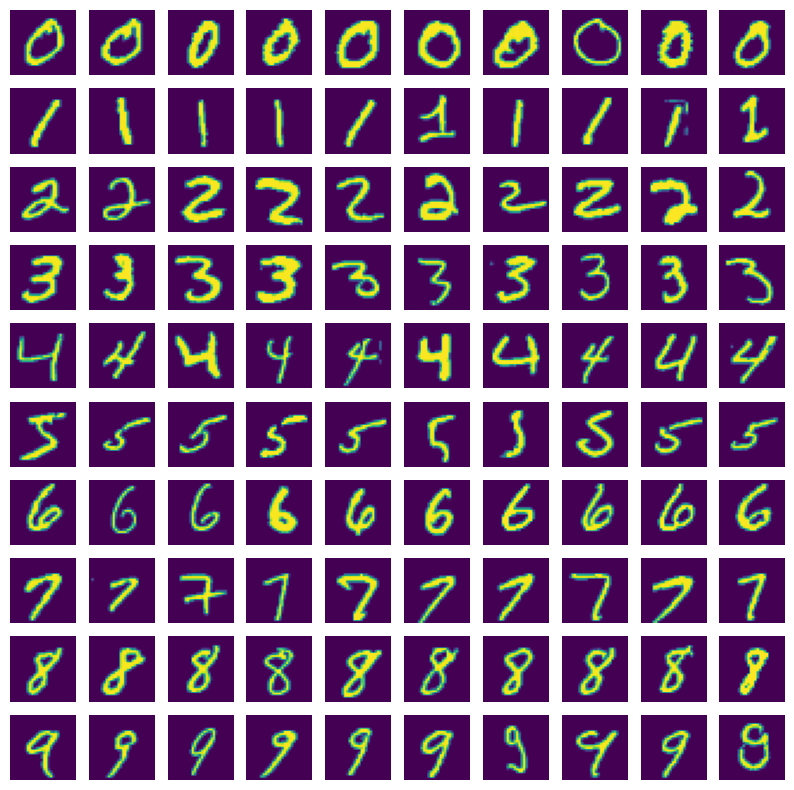

In [8]:
visulaization_dataset(x_train_2, y_train_2)

### Generator Model

In [9]:

### defining the generative block
class generative_block(keras.layers.Layer):
  '''
    Generative Block
    ----------------
    > Transpose layer
    > batch norm
    > activation.
  '''
  def __init__(self,filters, kernal_size, strides,padding = 'valid', **kwargs):
    super().__init__(**kwargs)
    self.upsample = keras.layers.Conv2DTranspose(filters, kernal_size, strides, padding=padding)
    self.batchnorm = keras.layers.BatchNormalization()
    self.activation = keras.layers.Activation('relu')


  def call(self, inputs):
    x = self.upsample(inputs)
    x = self.batchnorm(x)
    x = self.activation(x)
    return x



### projection and resample the network
class project_resample(keras.layers.Layer):
  '''
    Projecting the latent vector to the higher dims and spatial dimensions
    and then reshaping the values projected dims.
  '''
  def __init__(self, outdims, **kwargs):
    super().__init__(**kwargs)
    self.project_layer = keras.layers.Dense(outdims, activation = "relu")
    self.reshape = keras.layers.Reshape(target_shape= (2,2,128))


  def call(self, inputs):
    x = self.project_layer(inputs)
    x = self.reshape(x)
    return x



### Generative Model
class Generator(keras.Model):
  '''
    > 1. Projection and Reshape block
    > 2. 3-4 generative blocks
    > 3. last layer (GEN layer).
  '''
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.project = project_resample(2*2*128)
    self.gen_block1 = generative_block(64, 3, 2, "same")  # 4 x 4 x 512
    self.gen_block2 = generative_block(32, 3, 2, "same") # 8 x 8 x 256
    self.gen_block3 = generative_block(16, 5, 2, "valid") # 16 x 16 x 128
    self.gen_block4 = generative_block(8, 5, 1, "valid") # 23 x 23 x 64
    self.image_gen = generative_block(1, 6, 1, "valid") # 28 x 28 x 1

  def call(self, inputs):
    x = self.project(inputs)
    x = self.gen_block1(x)
    x = self.gen_block2(x)
    x = self.gen_block3(x)
    x = self.gen_block4(x)
    x = self.image_gen(x)
    return x



### Generative Noise
def generate_noise(samples, dims):
   return tf.random.normal(shape=(samples, dims))


Getting the shape of the noise :  [ 1 28 28  1]


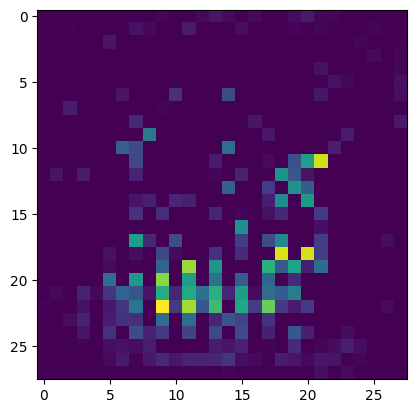

In [10]:
### sanity-checks
gen_net = Generator()
s = generate_noise(1, 128)
out = gen_net(s)
print("Getting the shape of the noise : ",tf.shape(out).numpy())

## showing the output image using the matplotlib
plt.imshow(out[0])

#### Discriminator Model
- Get input image
- classifies the image into real or fake.
- there is no fully connected layers in discriminator.

In [11]:
### defining the discriminator block
class discriminator_block(keras.layers.Layer):
  '''
    Discriminator Block
    --------------------
    > Convolution2D
    > we will high stride.
    > Batch Normalization
    > Activation
  '''

  def __init__(self,filters, kernel_size, strides, **kwargs):
    super().__init__(**kwargs)
    self.conv = keras.layers.Conv2D(filters, kernel_size, strides, padding = "same")
    self.batch_norm = keras.layers.BatchNormalization()
    self.activation = keras.layers.Activation("relu")

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.batch_norm(x)
    x = self.activation(x)
    return x



class Discriminator(keras.Model):
  '''
    || Discriminator Layers
    >> Lay 1: Block : Conv2d layers -> batch norm -> activation
    >> Global averaging
    >> Dense Layer for classification
  '''

  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.disc_block1 = discriminator_block(filters = 16, kernel_size = 3, strides = 2)
    self.disc_block2 = discriminator_block(filters = 32, kernel_size =3, strides = 2)
    self.disc_block3 = discriminator_block(filters = 64, kernel_size = 3, strides = 2)
    self.disc_block4 = discriminator_block(filters = 128, kernel_size = 3, strides = 2)
    self.global_average = keras.layers.GlobalAvgPool2D()
    self.classifier = keras.layers.Dense(1)



  def call(self, inputs):
    x = self.disc_block1(inputs)
    x = self.disc_block2(x)
    x = self.disc_block3(x)
    # x = self.disc_block4(x)
    x = self.global_average(x)
    x = self.classifier(x)

    return x


In [12]:
### sanity-checking
sampl_img = tf.random.normal(shape=(128, 28,28,1))


In [13]:
disc_net = Discriminator()


In [14]:
from tensorflow.keras import layers

In [15]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

### Creating Data Loaders

In [17]:
### reshaping the training  and validation dataset
# x_train = x_train/255
x_train = np.expand_dims((x_train_2-255)/255, axis = -1)
y_train = np.expand_dims(y_train_2, axis = -1)

### Data Loaders

## converting the features in to the tensors
features = tf.convert_to_tensor(x_train)
labels = tf.convert_to_tensor(y_train)

features = tf.cast(features, dtype="float32")

dataloaders = tf.data.Dataset.from_tensor_slices((features, labels))
dataloaders = dataloaders.batch(CNF.batch_size)
# dataloaders = dataloaders.repeat()

#### Defining the Losses for training the Deep Convolutional GANS

In [27]:


### Lossses function
# ========================
criterion = keras.losses.BinaryCrossentropy(from_logits = True)
# generator_criterion = keras.losses.BinaryCrossentropy(from_logits = True)


def discriminator_loss(real_outputs, fake_outputs):
  ## discriminator loss ==> cross entropy
  real_labels = tf.ones(shape = (real_outputs.shape[0], 1))
  fake_labels = tf.zeros(shape = (fake_outputs.shape[0], 1))

  real_loss = criterion(real_labels, real_outputs)
  fake_loss =criterion(fake_labels, fake_outputs)

  return (real_loss + fake_loss)/2


def generater_loss(fake_outputs):
  ## generator loss => cross entropy
  labels = tf.ones(shape = (fake_outputs.shape[0], 1))
  loss = criterion(labels, fake_outputs)
  return loss


### OPTIMIZERS and Models
## ======================

# gen_network = Generator()
# disc_network = Discriminator()

gen_network = make_generator_model()
disc_network = make_discriminator_model()


## optimizer
gen_optimizer = keras.optimizers.Adam(learning_rate=CNF.lr)
disc_optimizer = keras.optimizers.Adam(learning_rate = CNF.lr)

### Training

In [28]:
### training step updating the gradient and checking the results
def train_step(fake_noise, real_image):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    ## forward pass
    fake_imgs = gen_network(fake_noise)

    fake_outs = disc_network(fake_imgs)

    real_outs = disc_network(real_image)

    ## losses
    gen_loss = generater_loss(fake_outs)
    disc_loss = discriminator_loss(real_outs, fake_outs)


  ## getting discriminator grads and update weights
  disc_grads = disc_tape.gradient(disc_loss, disc_network.trainable_variables)
  disc_optimizer.apply_gradients(zip(disc_grads, disc_network.trainable_variables))

  ## getting generator grads and update weights
  gen_grads = gen_tape.gradient(gen_loss, gen_network.trainable_variables)
  gen_optimizer.apply_gradients(zip(gen_grads, gen_network.trainable_variables))

  return gen_loss, disc_loss



Epoch : 1/20


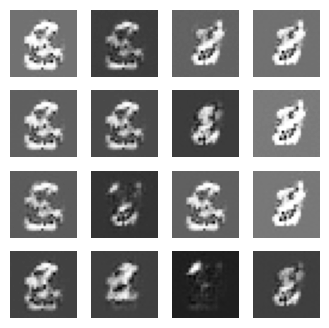

|| Generator Loss : 2.3884246349334717 , Discriminator Loss 0.09814629703760147
Epoch : 2/20


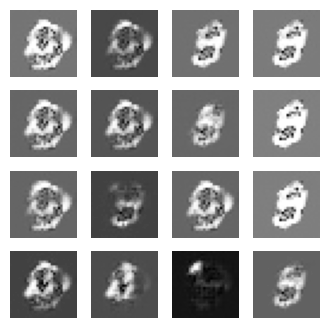

|| Generator Loss : 2.617736577987671 , Discriminator Loss 0.0893615186214447
Epoch : 3/20


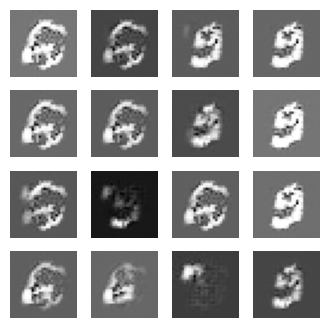

|| Generator Loss : 2.735607385635376 , Discriminator Loss 0.08777178823947906
Epoch : 4/20


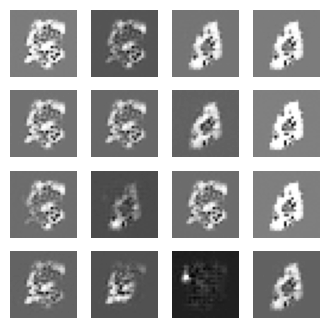

|| Generator Loss : 3.2515528202056885 , Discriminator Loss 0.07973182946443558
Epoch : 5/20


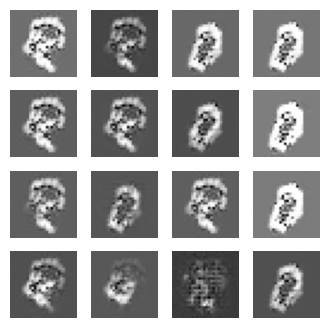

|| Generator Loss : 2.5138871669769287 , Discriminator Loss 0.08461686968803406
Epoch : 6/20


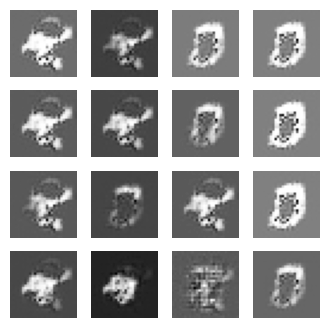

|| Generator Loss : 2.712453603744507 , Discriminator Loss 0.08585360646247864
Epoch : 7/20


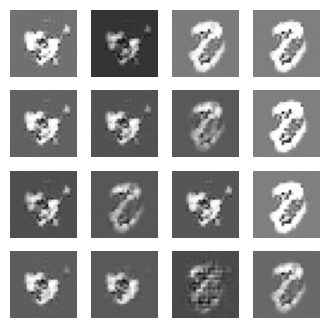

|| Generator Loss : 2.7067878246307373 , Discriminator Loss 0.07669445872306824
Epoch : 8/20


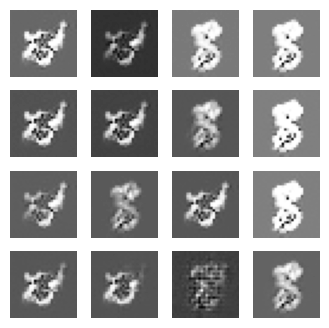

|| Generator Loss : 3.298977851867676 , Discriminator Loss 0.055261269211769104
Epoch : 9/20


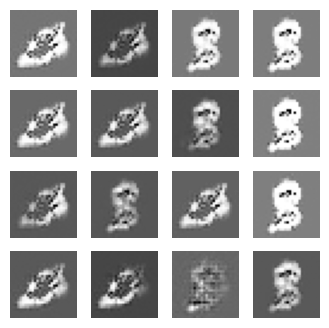

|| Generator Loss : 3.1318323612213135 , Discriminator Loss 0.06308980286121368
Epoch : 10/20


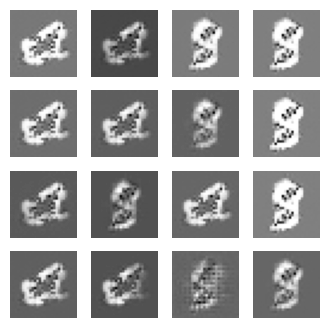

|| Generator Loss : 2.46575927734375 , Discriminator Loss 0.1270614117383957
Epoch : 11/20


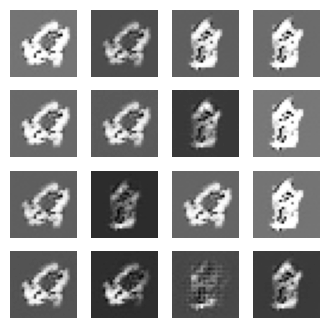

|| Generator Loss : 2.9798104763031006 , Discriminator Loss 0.0756402313709259
Epoch : 12/20


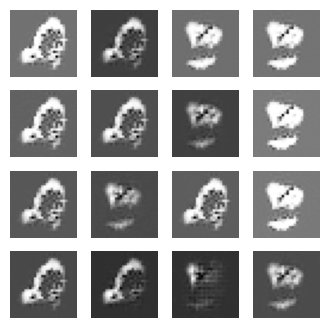

|| Generator Loss : 2.7907960414886475 , Discriminator Loss 0.0699196457862854
Epoch : 13/20


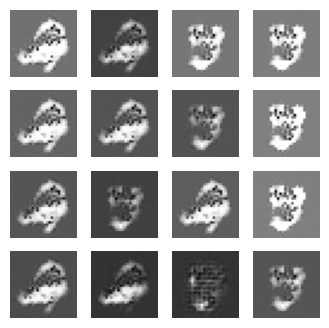

|| Generator Loss : 2.33674955368042 , Discriminator Loss 0.12224169075489044
Epoch : 14/20


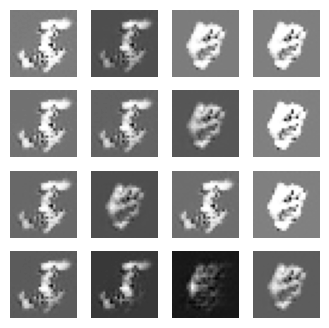

|| Generator Loss : 2.9707159996032715 , Discriminator Loss 0.1126263290643692
Epoch : 15/20


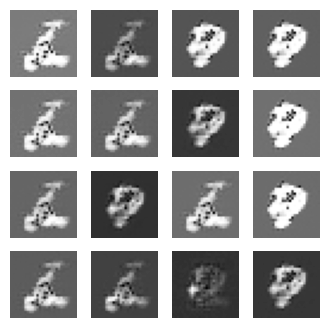

|| Generator Loss : 1.9931230545043945 , Discriminator Loss 0.12487728893756866
Epoch : 16/20


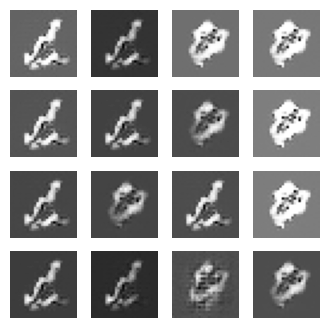

|| Generator Loss : 3.428436756134033 , Discriminator Loss 0.059018395841121674
Epoch : 17/20


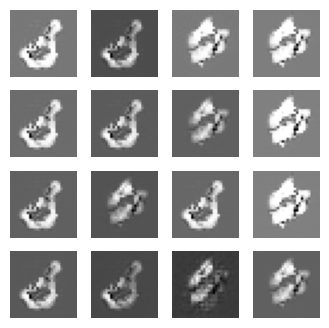

|| Generator Loss : 2.551943778991699 , Discriminator Loss 0.10130658000707626
Epoch : 18/20


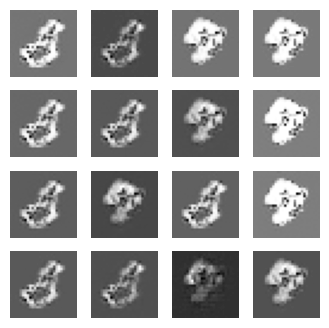

|| Generator Loss : 3.8048477172851562 , Discriminator Loss 0.07344178855419159
Epoch : 19/20


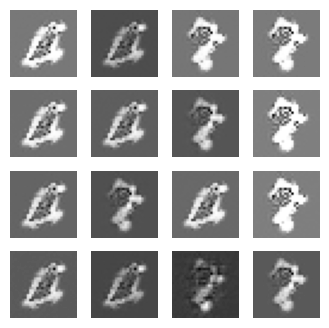

|| Generator Loss : 2.1384081840515137 , Discriminator Loss 0.154549241065979
Epoch : 20/20


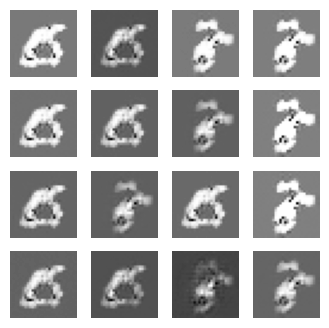

|| Generator Loss : 2.1849122047424316 , Discriminator Loss 0.11191360652446747


In [33]:
### training the Network
steps =0
seed = tf.random.normal([16, 100])
for epoch in range(CNF.epochs):
  print("Epoch : {}/{}".format(epoch+1, CNF.epochs))

  for real_image,_ in dataloaders:
    steps += 1
    fake_noise = generate_noise(CNF.batch_size, 100)
    gen_loss, disc_loss = train_step(fake_noise, real_image)


  generate_and_save_images(gen_network,
                           epoch,
                           seed)
  print("|| Generator Loss : {} , Discriminator Loss {}".format(gen_loss, disc_loss))




In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [74]:
img = gen_network(noise)

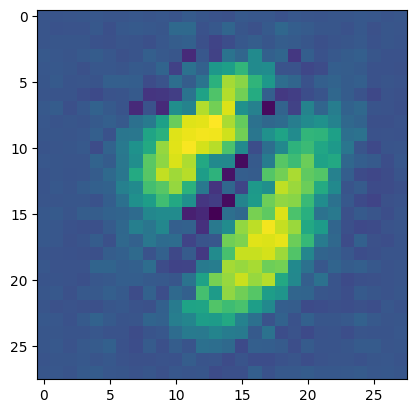

In [75]:
plt.imshow(img[0])